In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [2]:
data_file= 'data/dataset.pkl'

In [3]:
#dictionary to map parties to num for tensors
party_dict={'SPÖ':0,'ÖVP':1,'FPÖ':2,'Grüne':3,'LIF':4,'BZÖ':5,'NEOS':6,'STRONACH':7,'PILZ':8,'independent':9}

In [5]:
'''
takes data set and filters out independet speeches to a seperate list,
takes other speeches as list and
according party-labels are mapped to number as a list
'''
def load_data(data_file):
    df = pd.read_pickle(data_file)
    independent_df= df[df['party']=='independent']
    df = df[~(df['party']=='independent')]
    df= df[2000:3000]
    #print(df['party'])
    texts = df['text'].tolist()
    df['party'] = df['party'].map(party_dict)
    labels = df['party'].tolist()
    test_texts= independent_df['text'].tolist()
    print(df.value_counts('party'))
    #print(labels)
    return texts, labels, test_texts

In [6]:
texts,labels,test_texts = load_data(data_file)

party
1    329
0    281
2    194
3    188
4      8
dtype: int64


##### Distribution of labels with all speeches
[24747/87883,24063/87883,17308/87883,12455/87883,1942/87883,4170/87883,1866/87883,1322/87883,346/87883]

Distribution for sample 2000:3000
1    348/1000
0    268/1000
2    195/1000
3    186/1000
4      3/1000

In [7]:
'''
takes a list of texts and a list of labels and returns a tensor with tokenzied text and labels
truncated with given maximal length and using predefined tokenizer
'''
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label,dtype=torch.long)}

In [8]:
'''
BERT Classifier with a BERT layer, Dropout layer and a linear layer
'''
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [9]:
'''
training function loads in batches
crossentropyloss with weights according to distribution of labels in training data
'''
def train(model, data_loader, optimizer, scheduler, device, weights):
    model.train()
    cross_entropy_loss=0
    for batch in data_loader:
        #Reset gradients before first run - if training
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        #forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        #cross_entropy_loss.append(loss)
        #backpropagation with optimizer step
        loss.backward()
        cross_entropy_loss+=loss.item()
        optimizer.step()
        scheduler.step()
    cross_entropy_loss= cross_entropy_loss/len(data_loader)
    return cross_entropy_loss

In [10]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    all_probs = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            #softmax activation function whyyyyy 1 and 0
            probs = nn.functional.softmax(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions), all_probs

In [11]:
def predict_party(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        
    return preds.item()

In [12]:
# Set up parameters
#bert_model_name = 'bert-base-uncased'
bert_model_name= 'bert-base-german-cased'
#n-classes depends on sample size, actually 10
num_classes = 5
max_length = 128
batch_size = 10
num_epochs = 5
learning_rate = 2e-5
#because the data set is not balanced n sample to implement weights in loss function
class_weights= torch.tensor([31/100,23/100,25/100,21/100])
# [1/nsamplesperclass]
#class_weights = torch.tensor([24747/87883,24063/87883,17308/87883,12455/87883,1942/87883,4170/87883,1866/87883,1322/87883,346/87883])

In [13]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [14]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
tokenizer.truncation_side= "left"
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

C:\Users\sarah\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
for batch in train_dataloader:
    print("Batch keys:", batch.keys())
    print("Batch features shape:", batch['features'].shape)  # Should be [batch_size, input_dim]
    print("Batch labels shape:", batch['label'].shape)      # Should be [batch_size]
    break

Batch keys: dict_keys(['input_ids', 'attention_mask', 'label'])


KeyError: 'features'

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
#not sure if SGD would be better?
optimizer = AdamW(model.parameters(), lr=learning_rate)
#optimizer =
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

C:\Users\sarah\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
loss_graph=[]

In [19]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        cross_entropy_loss = train(model, train_dataloader, optimizer, scheduler, device, class_weights)
        accuracy, report, probabilities = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)
        print(probabilities)
        print(cross_entropy_loss)
        loss_graph.append(cross_entropy_loss)

Epoch 1/5


C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.3400
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        64
           1       0.33      0.98      0.50        63
           2       0.00      0.00      0.00        41
           3       0.40      0.07      0.12        28
           4       0.00      0.00      0.00         4

    accuracy                           0.34       200
   macro avg       0.25      0.22      0.15       200
weighted avg       0.32      0.34      0.21       200

[[0.1501069962978363, 0.5415072441101074, 0.2423843890428543, 0.052603304386138916, 0.013398073613643646], [0.20838767290115356, 0.5528419613838196, 0.15755513310432434, 0.06960504502058029, 0.011610232293605804], [0.32425329089164734, 0.29030802845954895, 0.1786903291940689, 0.19566784799098969, 0.011080377735197544], [0.26021498441696167, 0.44964975118637085, 0.19252261519432068, 0.0856640636920929, 0.011948463506996632], [0.19399403035640717, 0.5202205181121826, 0.20315028727

C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.4750
              precision    recall  f1-score   support

           0       0.48      0.34      0.40        64
           1       0.70      0.67      0.68        63
           2       0.39      0.22      0.28        41
           3       0.31      0.79      0.44        28
           4       0.00      0.00      0.00         4

    accuracy                           0.47       200
   macro avg       0.38      0.40      0.36       200
weighted avg       0.50      0.47      0.46       200

[[0.08594880253076553, 0.43285873532295227, 0.4494163990020752, 0.02597496286034584, 0.005801109131425619], [0.3658751845359802, 0.34668415784835815, 0.10276000946760178, 0.17659853398799896, 0.008082020096480846], [0.26808393001556396, 0.03410424664616585, 0.0709596574306488, 0.612450361251831, 0.01440175250172615], [0.4376979470252991, 0.1321866512298584, 0.17665217816829681, 0.240957111120224, 0.01250605657696724], [0.1543472856283188, 0.5117879509925842, 0.25388336181640625,

C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5100
              precision    recall  f1-score   support

           0       0.51      0.56      0.53        64
           1       0.52      0.79      0.63        63
           2       0.50      0.17      0.25        41
           3       0.47      0.32      0.38        28
           4       0.00      0.00      0.00         4

    accuracy                           0.51       200
   macro avg       0.40      0.37      0.36       200
weighted avg       0.50      0.51      0.47       200

[[0.028078876435756683, 0.5598620772361755, 0.40069371461868286, 0.006109269335865974, 0.0052561028860509396], [0.21663683652877808, 0.6588444113731384, 0.09094128757715225, 0.027989685535430908, 0.005587853025645018], [0.45649367570877075, 0.023525508120656013, 0.03464105725288391, 0.4676399230957031, 0.01769985258579254], [0.48350146412849426, 0.20423635840415955, 0.2505841851234436, 0.051915980875492096, 0.009762040339410305], [0.05368096008896828, 0.730087161064148, 0.199157

C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5300
              precision    recall  f1-score   support

           0       0.54      0.52      0.53        64
           1       0.56      0.78      0.65        63
           2       0.48      0.29      0.36        41
           3       0.44      0.43      0.44        28
           4       0.00      0.00      0.00         4

    accuracy                           0.53       200
   macro avg       0.41      0.40      0.40       200
weighted avg       0.51      0.53      0.51       200

[[0.01654726080596447, 0.41348227858543396, 0.5601692795753479, 0.00470722047612071, 0.005094018764793873], [0.13623708486557007, 0.7584438920021057, 0.08728315681219101, 0.01383760292083025, 0.004198218695819378], [0.2821735441684723, 0.009738771244883537, 0.018934432417154312, 0.6666969060897827, 0.022456327453255653], [0.7468637228012085, 0.08736895769834518, 0.10726906359195709, 0.050435010343790054, 0.008063247427344322], [0.03543255478143692, 0.6761487126350403, 0.27227631

Validation Accuracy: 0.5100
              precision    recall  f1-score   support

           0       0.48      0.53      0.50        64
           1       0.64      0.60      0.62        63
           2       0.44      0.39      0.42        41
           3       0.41      0.50      0.45        28
           4       0.00      0.00      0.00         4

    accuracy                           0.51       200
   macro avg       0.40      0.40      0.40       200
weighted avg       0.50      0.51      0.51       200

[[0.014139531180262566, 0.287685751914978, 0.6888929009437561, 0.004362752661108971, 0.004919108934700489], [0.27752751111984253, 0.5484423041343689, 0.14253991842269897, 0.026161959394812584, 0.005328225903213024], [0.21043163537979126, 0.0068855551071465015, 0.016111986711621284, 0.7472229599952698, 0.019347872585058212], [0.8215557336807251, 0.03913801535964012, 0.0724915936589241, 0.05978919938206673, 0.007025559898465872], [0.030914003029465675, 0.5472410321235657, 0.404785

C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


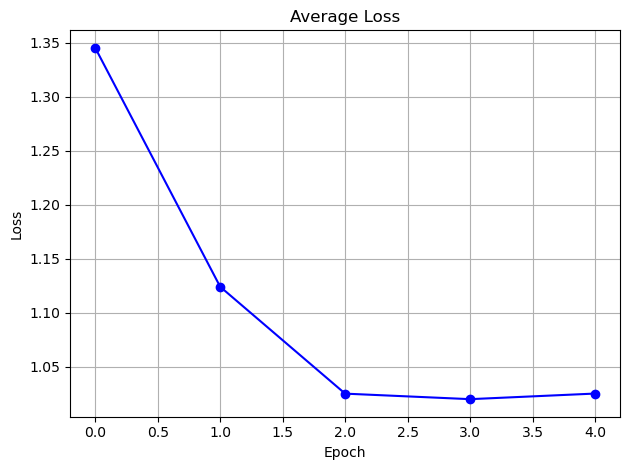

In [34]:
import matplotlib.pyplot as plt

# Create a simple line plot
plt.plot(loss_graph, marker='o', linestyle='-', color='blue')

# Add title and labels
plt.title("Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the graph
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
torch.save(model.state_dict(), "data/bert_classifier_test.pth")

In [56]:
print(train_texts[0])

 Herr Präsident! Herr Staatssekretär! Hohes Haus! Zu dieser hier angesprochenen Verunsicherung hat sicherlich nicht die Bundesregierung beigetragen, sondern zu einem Großteil haben die Streiks dazu beigetragen. Vorhin hat ja eine Kollegin gesagt, dass sich niemand von uns zu den Streiks geäußert hätte; ich kann das ja nun ein wenig tun. Ich würde gerne ein paar Pressestimmen hiezu bringen. Im „Kurier“ von heute heißt es: Der Streik ist vorbei, und nichts hat er gebracht. Bekanntlich hat der ÖGB die Gespräche abgebrochen und gemeint, streiken sei sinnvoller als verhandeln.“ Die „Presse“ schreibt: Der ÖGB wollte es wissen. Jetzt weiß er es. Die Österreicher sind nicht in eine Radikalisierung hineintreibbar. Damit ist auch das Gewicht des ÖGB zum Segen des Landes reduziert. In den „Oberösterreichische Nachrichten“ heißt es: Hätten nicht Fernsehen und Zeitungen so ausführlich berichtet, wäre der gestrige Streik an der Mehrheit der nicht auf öffentliche Verkehrsmittel angewiesenen Bürger be

In [38]:
# Test party classification."
test_text= "Österreich muss aktiv in erneuerbare Energien investieren um unsere Umwelt zu schützen."
test_text1= "Wir müssen die Zuwanderung stoppen um unseren Leuten ein gutes Österreich zu ermöglichen."
test_text2= "Für eine gerechte Gesellschaft braucht es mehr Umverteilung von oben nach unten."
test_text3= "Leistung muss sich wieder lohnen. Wer hart arbeitet, soll gut leben."
party = predict_party(test_text, model, tokenizer, device)
party1 = predict_party(test_text1, model, tokenizer, device)
party2 = predict_party(test_text2, model, tokenizer, device)
party3 = predict_party(test_text3, model, tokenizer, device)
print(test_text)
print(f"Predicted party: {party}")
print(test_text1)
print(f"Predicted party: {party1}")
print(test_text2)
print(f"Predicted party: {party2}")
print(test_text3)
print(f"Predicted party: {party3}")

Österreich muss aktiv in erneuerbare Energien investieren um unsere Umwelt zu schützen.
Predicted party: 1
Wir müssen die Zuwanderung stoppen um unseren Leuten ein gutes Österreich zu ermöglichen.
Predicted party: 1
Für eine gerechte Gesellschaft braucht es mehr Umverteilung von oben nach unten.
Predicted party: 1
Leistung muss sich wieder lohnen. Wer hart arbeitet, soll gut leben.
Predicted party: 1


In [36]:
# Test party classification."
test_text= train_texts[0]
test_text1= train_texts[1]
test_text2= train_texts[2]
test_text3= train_texts[3]
party = predict_party(test_text, model, tokenizer, device)
party1 = predict_party(test_text1, model, tokenizer, device)
party2 = predict_party(test_text2, model, tokenizer, device)
party3 = predict_party(test_text3, model, tokenizer, device)
print(train_labels[0])
print(test_text)
print(f"Predicted party: {party}")
print(train_labels[1])
print(test_text1)
print(f"Predicted party: {party1}")
print(train_labels[2])
print(test_text2)
print(f"Predicted party: {party2}")
print(train_labels[3])
print(test_text3)
print(f"Predicted party: {party3}")

3
 Herr Präsident! Herr Bundesminister! Geschätztes Hohes Haus! Herr Abgeordneter Wittauer, gerne würden wir dieses Gesetz unterstützen, wir haben das ja bereits im Ausschuss ziemlich ausführlich erörtert und einige positive Dinge auch positiv angemerkt. Es sind darin ja auch immerhin Anregungen der Grünen aufgenommen worden, so zum Beispiel eine Bestandsaufnahme über den Zustand der Gewässer, was ja auch in der Wasserrahmenrichtlinie vorgesehen ist. Weiters: Ausmaß der Belastungen, Erhalt und Verbesserung des Zustands, aber, wie Kollegin Glawischnig schon erwähnt hat: nichts vom ökologischen Hochwasserschutz ist darin enthalten! HQ 100 wird nicht eingehalten, sondern das geht zurück auf HQ 30, obwohl auch die Salzburger sehr dafür gewesen wären. Der besondere Schutz der österreichischen Wasserressourcen, den Sie, Frau Kollegin Achleitner, ja auch angesprochen haben, wurde in der Ausschusssitzung nicht besonders positiv beurteilt. Unser Entschließungsantrag wurde zwar zur Kenntnis geno

if training data is not being predicted it needs more epochs
-> training data exactly with the same truncation as training 

In [58]:
train_dataset = TfidfDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TfidfDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

TypeError: __init__() takes 3 positional arguments but 5 were given

rather scikit learn w/o pytorch

In [ ]:
torch.save(model.state_dict(), "data/logreg_classifier.pth")

In [40]:
# Test party classification."
test_text= train_texts[0]
test_text1= train_texts[1]
test_text2= train_texts[2]
test_text3= train_texts[3]
party = predict_party(test_text, model, tokenizer, device)
party1 = predict_party(test_text1, model, tokenizer, device)
party2 = predict_party(test_text2, model, tokenizer, device)
party3 = predict_party(test_text3, model, tokenizer, device)
print(train_labels[0])
print(test_text)
print(f"Predicted party: {party}")
print(train_labels[1])
print(test_text1)
print(f"Predicted party: {party1}")
print(train_labels[2])
print(test_text2)
print(f"Predicted party: {party2}")
print(train_labels[3])
print(test_text3)
print(f"Predicted party: {party3}")

3
 Herr Präsident! Herr Bundesminister! Geschätztes Hohes Haus! Herr Abgeordneter Wittauer, gerne würden wir dieses Gesetz unterstützen, wir haben das ja bereits im Ausschuss ziemlich ausführlich erörtert und einige positive Dinge auch positiv angemerkt. Es sind darin ja auch immerhin Anregungen der Grünen aufgenommen worden, so zum Beispiel eine Bestandsaufnahme über den Zustand der Gewässer, was ja auch in der Wasserrahmenrichtlinie vorgesehen ist. Weiters: Ausmaß der Belastungen, Erhalt und Verbesserung des Zustands, aber, wie Kollegin Glawischnig schon erwähnt hat: nichts vom ökologischen Hochwasserschutz ist darin enthalten! HQ 100 wird nicht eingehalten, sondern das geht zurück auf HQ 30, obwohl auch die Salzburger sehr dafür gewesen wären. Der besondere Schutz der österreichischen Wasserressourcen, den Sie, Frau Kollegin Achleitner, ja auch angesprochen haben, wurde in der Ausschusssitzung nicht besonders positiv beurteilt. Unser Entschließungsantrag wurde zwar zur Kenntnis geno

#### apply the train data on the model -> if it predicts good/ otherwise something is wrong with the training
